# Object Detection with Region Based Convolutional Neural Network.

You should have seen in our previous posts that Convolutional Neural Network is the state of the art for any computer vision task like

- [Image classification](https://www.learnopencv.com/pytorch-for-beginners-image-classification-using-pre-trained-models/)


- [Semantic Segmentation](https://www.learnopencv.com/pytorch-for-beginners-semantic-segmentation-using-torchvision/)

In this notebook we will look at another computer vision application called object detection

## Object Detection
  
  In image classification, we assign a single label (e.g. cat, dog, etc.) to the entire image. This is adequate for many tasks where the location of the object you are interested in is not important.
  
  On the other hand, there can be multiple objects in the image, and the application may demand not just identifying the objects, but also locating them in the image.

  For such tasks we need Object Detection. In this category of techniques, the input to the model is an image, and the output is an array of bounding boxes, and a class label for every bounding box.

  The main challenge here is that there might be a varying number of objects in every input image.

  Conceptually, Object Detection sits in between Image Classification and Image Segmentation (every pixel is assigned a class label).
  
  Classification is blazingly fast but the output is just a single class label for the entire image.
  
  Segmentation provides a detailed output - a class label for every pixel -  but is slow.
  
  Object Detection, serves as a happy compromise - fast, and with enough localization accuracy for many tasks.


### Sliding Window Approach
  Sliding window is one of the oldest approach in object detection where the input image is split into multiple crops and each crop of the image is classified and if the crop contains a class, then the crop is decided as the bounding box. But this approach is never used in practice as each input image may have 1000s of such crops and each crop passing through the network for classification may take time.
  
### Region Proposal (RCNN)
  Image processing techniques are used to make list of proposed regions in the input image which are then sent through the network for classification. But this is computationally more efficient than sliding window approach as only fewer potential crops which may contain the object is classified by the network.
  
  <img src="https://learnopencv.com/wp-content/uploads/2022/10/rcnn-features.png">
  Image Source :  [Ross Girshick et al](https://arxiv.org/pdf/1311.2524.pdf)
  
  RCNN is better than sliding window, but its still computationally expensive as the network has to classify all the region proposals. It takes around 30-40s for inference of a single image.
  
  
### Fast Region Proposal (Fast RCNN)
  In fast RCNN, rather than getting region proposals and classifying each region proposals, the input image is sent into the CNN network which gives a feature map of the image. Again some region proposals are used but now we get the region proposals from the feature map of the image and these feature maps are classified. This reduces the computation as some of the CNN layers are common for the whole image.
  
  <img src="https://learnopencv.com/wp-content/uploads/2022/10/fast-rcnn-region-proposal.png">
  Image Source : [Ross Gishich](https://arxiv.org/pdf/1504.08083.pdf)
  

### Faster R-CNN
  The idea of Faster R-CNN is to use CNNs to propose potential region of interest and the network is called Region Proposal Network. After getting the region proposals , its just like Fast RCNN, we use every regions for classification.
<img src="https://learnopencv.com/wp-content/uploads/2022/10/faster-rcnn-region-proposal.png" width="600">

### Comparison - RCNN, Fast RCNN & Faster RCNN

| Feature                  | RCNN                                    | Fast RCNN                         | Faster RCNN                        |
|--------------------------|----------------------------------------|-----------------------------------|-------------------------------------|
| **Year**                 | 2014                                   | 2015                              | 2015                                |
| **Region Proposal Method** | Selective Search                      | Selective Search                  | Region Proposal Network (RPN)      |
| **CNN Processing**       | Separate CNN per region (~2,000 times) | Single CNN for entire image       | Single CNN for entire image        |
| **Speed**               | Very slow (40-50 sec/image)            | Faster (~2 sec/image)             | Fastest (~0.2 sec/image)           |
| **Accuracy**            | Good                                   | Better                            | Best                               |
| **End-to-End Trainable?** | No                                     | Yes                               | Yes                                |
| **Main Drawback**       | Too slow                               | Still uses Selective Search       | High computation for large images  |



# Object Detection with PyTorch

The pretrained Faster-RCNN ResNet-50 model we are going to use expects the input image tensor to be in the form ```[n, c, h, w]```
where
- n is the number of images
- c is the number of channels , for RGB images its 3
- h is the height of the image
- w is the widht of the image

The model will return
- Bounding boxes [x0, y0, x1, y1]  all all predicted classes of shape (N,4) where N is the number of classes predicted by the model to be present in the image.
- Labels of all predicted classes.
- Scores of each predicted label.



In [ ]:
# import necessary libraries
from PIL import Image

import matplotlib.pyplot as plt
import torch
import torchvision.transforms as T
import torchvision
import torch
import numpy as np
import cv2
import os
import subprocess
import requests
import glob

In [ ]:
np.random.seed(20)

In [ ]:
# get the pretrained model from torchvision.models
# Note: pretrained=True will get the pretrained weights for the model.
# model.eval() to use the model for inference
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(
    weights=torchvision.models.detection.FasterRCNN_ResNet50_FPN_Weights.DEFAULT
)
model.eval()

# Class labels from official PyTorch documentation for the pretrained model
# Note that there are some N/A's
# for complete list check https://tech.amikelive.com/node-718/what-object-categories-labels-are-in-coco-dataset/
# we will use the same list for this notebook
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

COLORS = np.random.uniform(0, 255, size=(len(COCO_INSTANCE_CATEGORY_NAMES), 3))

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 110MB/s]


Let's create a few helper functions to run inference on the image and display the output bounding boxes on the image.

In [ ]:
def get_prediction(img_path, threshold):
    """
    Perform a forward pass through the model to make predictions.

    Parameters:
        img_path (str): Path to the input image.
        threshold (float): Minimum confidence score for filtering predictions.

    Returns:
        pred_boxes (list of tuples): Bounding box coordinates [(x1, y1), (x2, y2)].
        pred_class (list of str): Predicted class names for each bounding box.
    """

    # Open the image using PIL
    img = Image.open(img_path)

    # Convert the image to a PyTorch tensor
    transform = T.Compose([T.ToTensor()])
    img = transform(img)

    # Perform inference (forward pass)
    pred = model([img])

    # Extract predictions and detach them from the computation graph
    pred_data = pred[0]

    # Convert tensors to NumPy arrays
    labels = pred_data['labels'].detach().cpu().numpy()
    boxes = pred_data['boxes'].detach().cpu().numpy()
    scores = pred_data['scores'].detach().cpu().numpy()

    # Filter predictions based on threshold
    valid_indices = scores > threshold

    # Keep only valid bounding boxes and class labels
    pred_boxes = [((b[0], b[1]), (b[2], b[3])) for b in boxes[valid_indices]]
    pred_class = [COCO_INSTANCE_CATEGORY_NAMES[i] for i in labels[valid_indices]]

    return pred_boxes, pred_class




def object_detection_api(
    img_path,
    threshold=0.5
):
    """
    Annotates the image with bounding boxes and class names.
    It calls the `get_prediction` function as well.
    parameters:
        img_path: path of the input image
        threshold: threshold value for prediction score
    method:
      - prediction is obtained from get_prediction method
      - for each prediction, bounding box is drawn and text is written
        with opencv
      - the final image is displayed
    """

    # Get predictions (bounding boxes and class labels) for the image
    boxes, pred_cls = get_prediction(img_path, threshold)

    # Read image using OpenCV
    img = cv2.imread(img_path)
    # Convert from OpenCV's default BGR format to RGB for correct visualization
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # Calculate thickness for drawing bounding boxes based on image size
    rect_th = max(round(sum(img.shape) / 2 * 0.003), 2)
    # Calculate thickness for the text annotations
    text_th = max(rect_th - 1, 1)

    # Iterate through each detected object
    for i in range(len(boxes)):
        # Extract bounding box coordinates from the prediction output
        p1, p2 = (int(boxes[i][0][0]), int(boxes[i][0][1])), (int(boxes[i][1][0]), int(boxes[i][1][1]))

        # Get color corresponding to the predicted class from a predefined color list
        color = COLORS[COCO_INSTANCE_CATEGORY_NAMES.index(pred_cls[i])]

        # Draw bounding box around the detected object
        cv2.rectangle(
            img,
            p1,  # Top-left corner
            p2,  # Bottom-right corner
            color=color,  # Bounding box color
            thickness=rect_th  # Line thickness
        )

        # Get the size (width and height) of the text to be displayed
        w, h = cv2.getTextSize(
            pred_cls[i],  # Object class name
            0,  # Font face
            fontScale=rect_th / 3,  # Scale font relative to box thickness
            thickness=text_th  # Text thickness
        )[0]  # Extract width and height

        # Determine if text label should be placed inside or outside the bounding box
        outside = p1[1] - h >= 3  # Check if there is enough space to put text above the box
        # Calculate coordinates for the background rectangle that holds the text
        p2 = p1[0] + w, p1[1] - h - 3 if outside else p1[1] + h + 3

        # Draw a filled rectangle for the class label background
        cv2.rectangle(
            img,
            p1,  # Top-left corner
            p2,  # Bottom-right corner
            color=color,  # Same as bounding box color
            thickness=-1,  # Filled rectangle
            lineType=cv2.LINE_AA  # Anti-aliased lines for smoother edges
        )

        # Overlay the text label on top of the filled rectangle
        cv2.putText(
            img,
            pred_cls[i],  # Class name
            (p1[0], p1[1] - 5 if outside else p1[1] + h + 2),  # Adjust text position
            cv2.FONT_HERSHEY_SIMPLEX,  # Font type
            rect_th / 3,  # Scale font size
            (255, 255, 255),  # White text color
            thickness=text_th + 1  # Text thickness
        )

    # Create a figure for displaying the image
    plt.figure(figsize=(15,12))
    # Display the image with bounding boxes and labels
    plt.imshow(img)
    # Remove x-axis ticks for a cleaner visualization
    plt.xticks([])
    # Remove y-axis ticks for a cleaner visualization
    plt.yticks([])
    # Show the final output image
    plt.show()


In [ ]:
# Helper function to download file.
def download_file(url, save_name):
    if not os.path.exists(save_name):
        subprocess.run(['wget', url, '-O', save_name, '-q'])

In [ ]:
# Create directory to donwload inference data.
inference_dir = 'inference_data'
os.makedirs(inference_dir, exist_ok=True)

## Person Detection

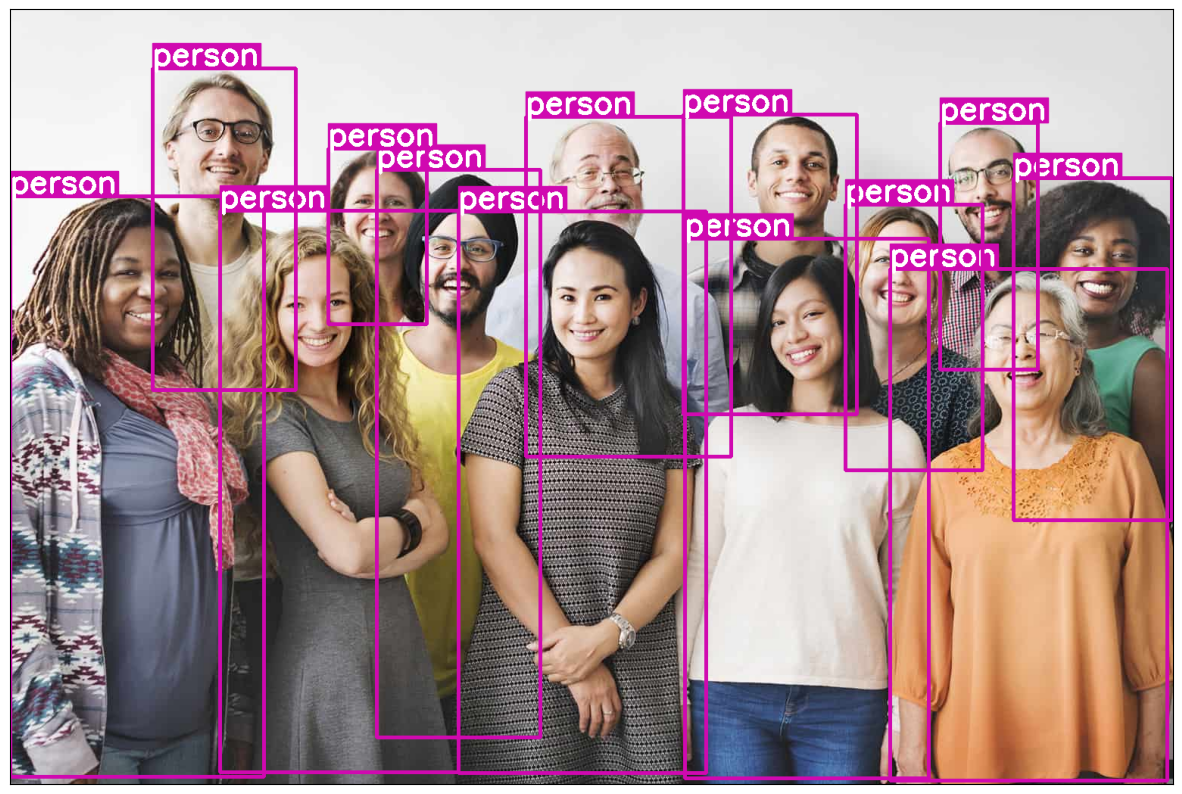

In [ ]:
download_file(
    'https://learnopencv.com/wp-content/uploads/2022/10/people.jpg',
    os.path.join(inference_dir, 'people.jpg')
)

# Use the api pipeline for object detection.
# The threshold is set manually, the model sometimes predicts
# andom structures as a potential object, so we set a threshold to keep objects
# with better prediction scores.
object_detection_api(os.path.join(inference_dir, 'people.jpg'), threshold=0.8)

## Vehicle Detection

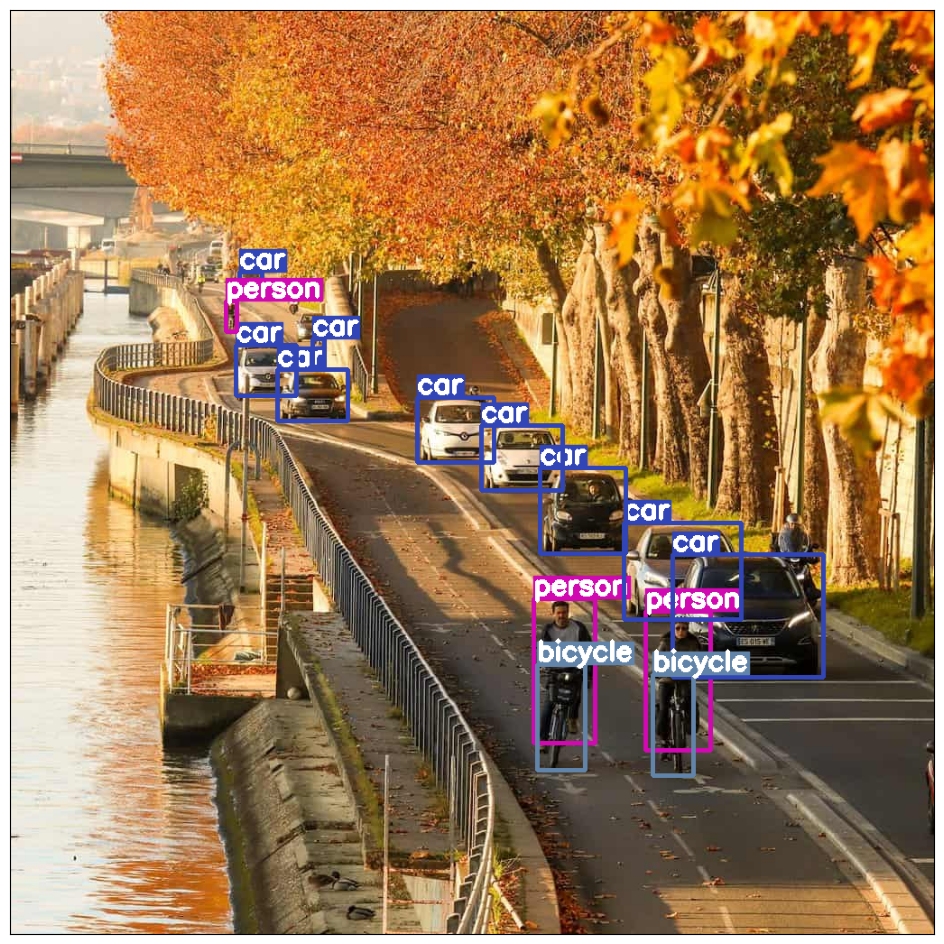

In [ ]:
download_file(
    'https://learnopencv.com/wp-content/uploads/2022/10/vehicles.jpg',
    os.path.join(inference_dir, 'vehicles.jpg')
)

object_detection_api(os.path.join(inference_dir, 'vehicles.jpg'), threshold=0.8)

## Traffic Detection

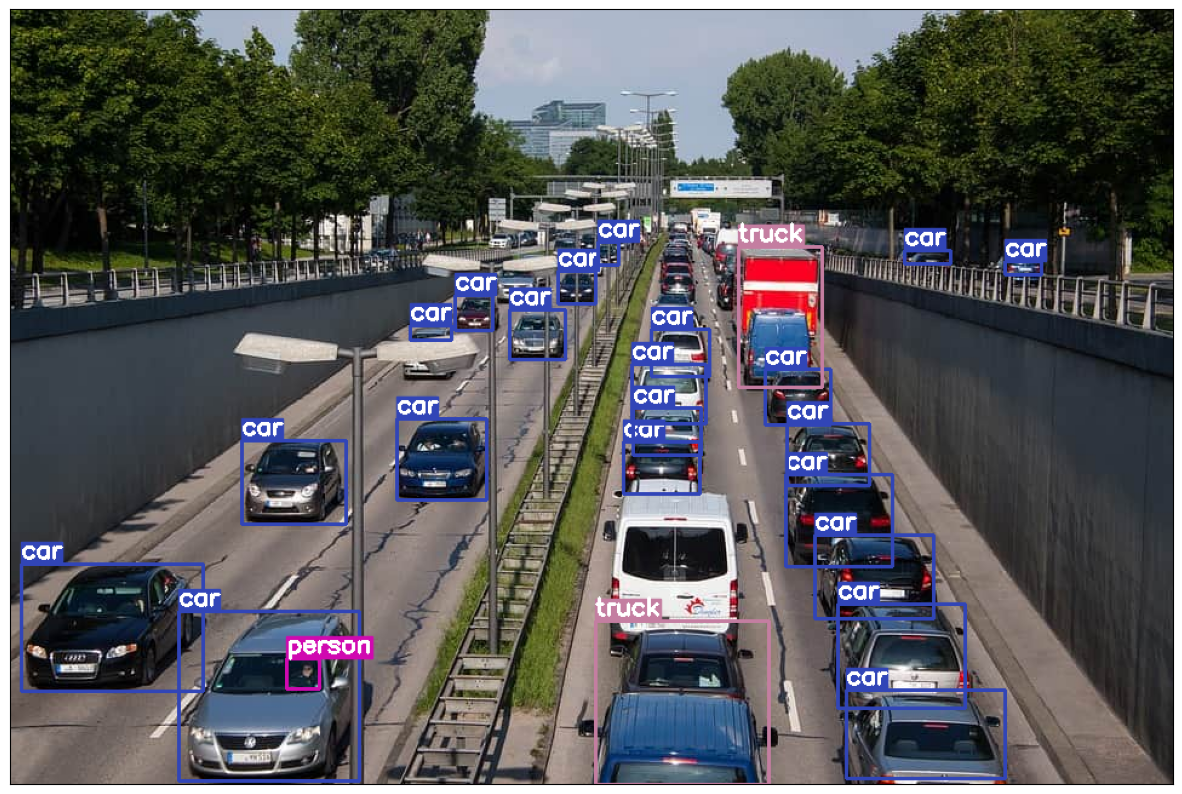

In [ ]:
download_file(
    'https://learnopencv.com/wp-content/uploads/2022/10/traffic_scene.jpg',
    os.path.join(inference_dir, 'traffic_scene.jpg')
)

object_detection_api(os.path.join(inference_dir, 'traffic_scene.jpg'), threshold=0.8)

## Low Lighting Detection

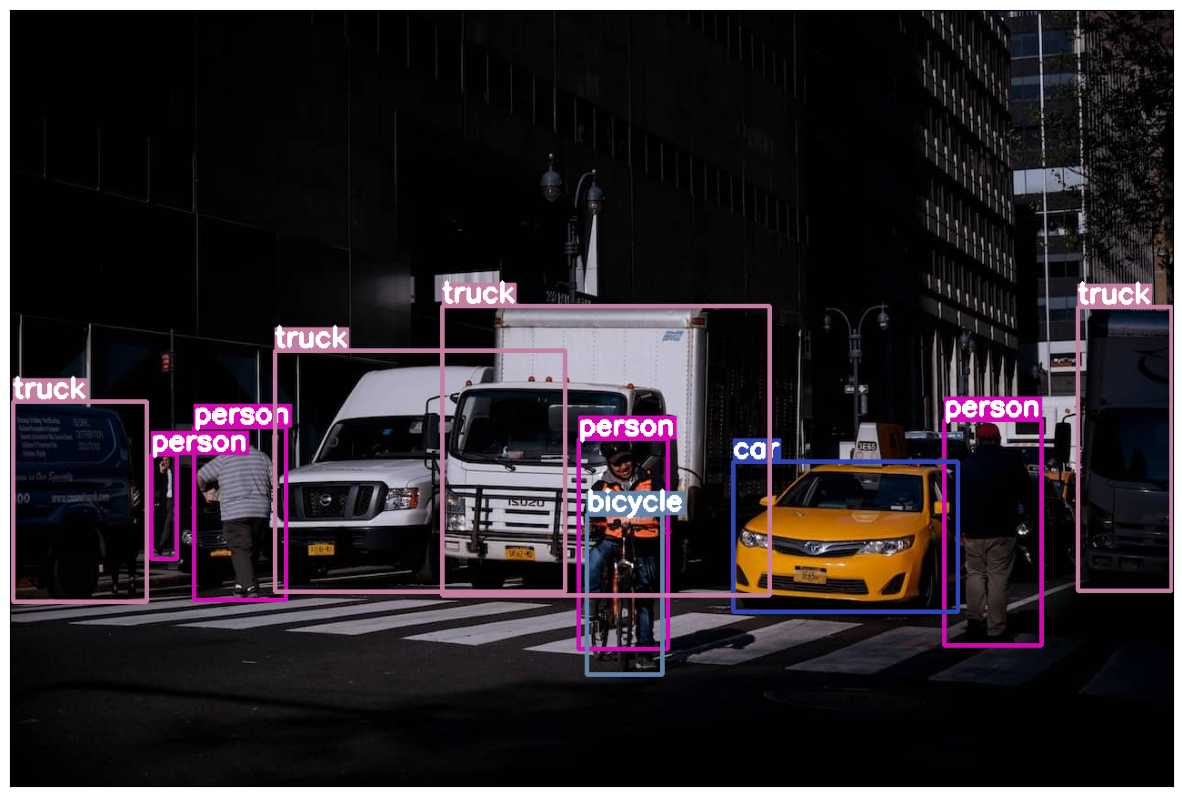

In [ ]:
download_file(
    'https://learnopencv.com/wp-content/uploads/2022/10/night-time.jpg',
    os.path.join(inference_dir, 'night-time.jpg')
)

object_detection_api(os.path.join(inference_dir, 'night-time.jpg'), threshold=0.8)

## Crowded Object Detection

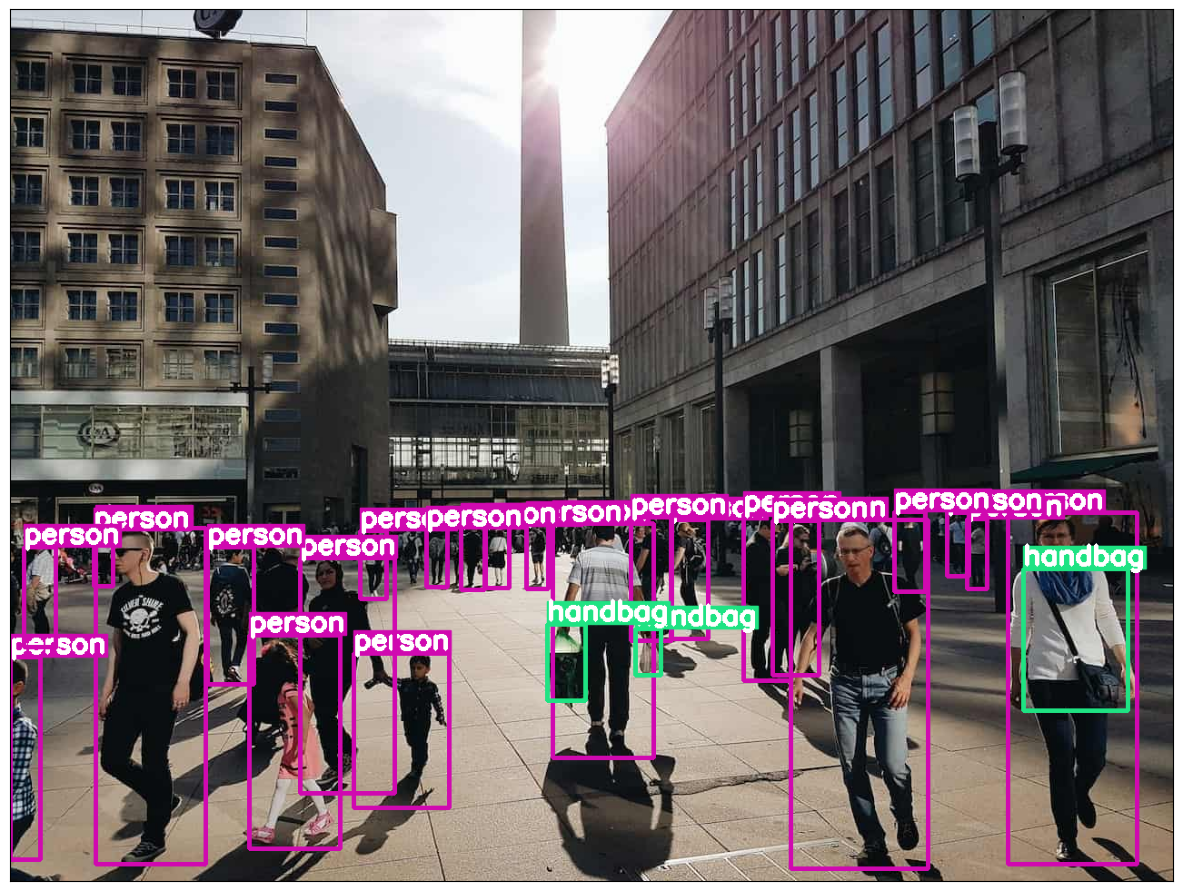

In [ ]:
download_file(
    'https://learnopencv.com/wp-content/uploads/2022/10/crowd.jpg',
    os.path.join(inference_dir, 'crowd.jpg')
)

object_detection_api(os.path.join(inference_dir, 'crowd.jpg'), threshold=0.8)

## Comparing the inference time of model in CPU & GPU

In [ ]:
import time  # Import time module to measure inference speed

# Load the pre-trained Faster R-CNN model
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(
    weights=torchvision.models.detection.FasterRCNN_ResNet50_FPN_Weights.DEFAULT
)
# Set model to evaluation mode
model.eval()


def check_inference_time(image_path, gpu=False):
    """
    Measures the inference time of the Faster R-CNN model on a given image.

    Parameters:
        image_path (str): Path to the input image.
        gpu (bool): Whether to run inference on GPU (default: False).

    Returns:
        float: Time taken (in seconds) for model inference.
    """

    # Open the image using PIL (Pillow)
    img = Image.open(image_path)

    # Convert image to a PyTorch tensor using torchvision transforms
    transform = T.Compose([T.ToTensor()])
    img = transform(img)

    # Move model and image to GPU or CPU based on the 'gpu' flag
    if gpu:
        model.cuda()  # Move model to GPU
        img = img.cuda()  # Move image to GPU
    else:
        model.cpu()  # Move model to CPU
        img = img.cpu()  # Move image to CPU (not strictly needed, but for consistency)

    # Start measuring inference time
    start_time = time.time()

    # Perform inference (forward pass)
    pred = model([img])

    # End time after inference is completed
    end_time = time.time()

    # Return the total time taken for inference
    return end_time - start_time


## Inference time for Object Detection

In [ ]:
# Let's run inference on all the downloaded images and average their inference time
img_paths = [
    path for path in glob.glob(os.path.join(inference_dir, '*')) \
    if path.split('.')[-1].lower() in ["jpeg", "jpg", "png"]
]
print(img_paths)
gpu_time = sum(
    [check_inference_time(img_path, gpu=True) \
     for img_path in img_paths])/len(img_paths
)
cpu_time = sum(
    [check_inference_time(img_path, gpu=False) \
     for img_path in img_paths])/len(img_paths
)


print('\n\nAverage Time take by the model with GPU = {}s\nAverage Time take by the model with CPU = {}s'.format(gpu_time, cpu_time))

['inference_data/people.jpg', 'inference_data/night-time.jpg', 'inference_data/traffic_scene.jpg', 'inference_data/vehicles.jpg', 'inference_data/crowd.jpg']


Average Time take by the model with GPU = 0.3576379299163818s
Average Time take by the model with CPU = 4.574804496765137s


# Interested in a Computer Vision & AI Career?

[OpenCV University](https://opencv.org/university/) provides the best path from basics to mastery in computer vision and AI. Check out [how our students are building spectacular AI careers](https://opencv.org/university/student-testimonials/)
.
  